<a href="https://colab.research.google.com/github/shefalishr95/Synthetic-data-generation-for-imbalanced-data/blob/main/SMOTE_replica_using_genAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

In [1]:
!pip install openai
!pip install config

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


In [214]:
# Load dependencies
import re
from io import StringIO
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn import metrics
from collections import Counter
from openai import OpenAI as openai
import os

In [3]:
# Load data
df = pd.read_csv("card_transdata.csv")

In [27]:
df.head(5)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [30]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


First, we verify if the target variable is indeed imbalanced in this dataset

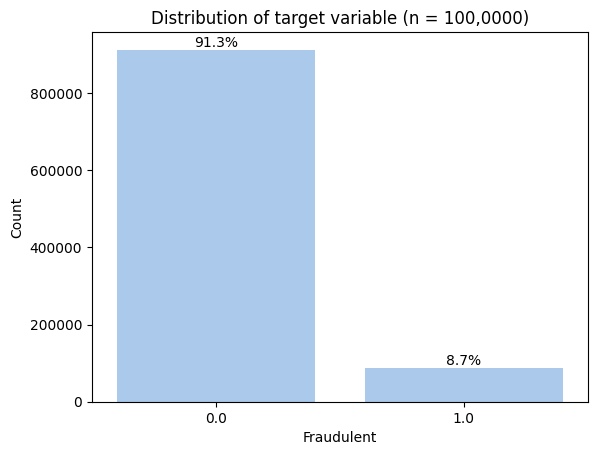

In [29]:
sns.set_palette("pastel6")
total = float(len(df['fraud']))

ax = sns.countplot(x='fraud', data=df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.1%}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')

ax.set_xlabel("Fraudulent")
ax.set_ylabel("Count")
ax.set_title("Distribution of target variable (n = 100,0000)")

plt.show()

We see that the dataset is highly imbalanced. We will proceed with data preprocessing steps.

As the main aim of this notebook is to generate syntehtic samples using existing distribution of minority class, we will apply minimal preprocessing steps, and move the focus to data generation.

In [ ]:
# Drop missing values and duplicates
df.drop_duplicates(inplace=True)

df = df.dropna(axis=0)

Next, we will randomly downsample the dataset. For this exercise, givent the limitation on token generation on OpenAI's free trial, we will work with a smaller dataset.

In [42]:
# Divide into features and target var
X = df.drop('fraud', axis=1)
y = df['fraud']

In [44]:
stratified_splitter = StratifiedShuffleSplit(n_splits=1, train_size=100, random_state=4242)

In [45]:
train_index, _ = next(stratified_splitter.split(X, y))
df_1 = df.iloc[train_index]

In [195]:
df_1['fraud'].value_counts()

fraud
0.0    91
1.0     9
Name: count, dtype: int64

df_1 has 100 samples and similar imbalanced distribution. Next, we will generate synthetic data for the minority class of the target variable.

# Synethetic Sample Generation

In [34]:
client = openai(api_key=os.environ.get('OPENAI_API_KEY', "OPENAI-API-KEY"))

In [120]:
question = """
Create a CSV with 82 rows of credit fraud data.
Each row should include the following fields:
- id (incrementing integer starting at 1)
- distance_from_home: Continuous variable, representing the distance from home where the transaction occurred. Values should follow a distribution with a mean of 23.05, standard deviation of 40.66, minimum of 0.21, and maximum of 329.48 kilometers.
- distance_from_last_transaction: Continuous variable, representing the distance from the last transaction. Values should follow a distribution with a mean of 6.72, standard deviation of 38.36, minimum of 0.01, and maximum of 521.13 kilometers.
- ratio_to_median_purchase_price: Continuous variable, representing the ratio of the purchase price to the median purchase price. Values should follow a distribution with a mean of 1.93, standard deviation of 2.89, minimum of 0.06, and maximum of 22.43.
- repeat_retailer: Binary variable, indicating whether the transaction occurred with the same retailer as the previous one. Values should follow a distribution with a mean of 0.87.
- used_chip: Binary variable, indicating whether the transaction was made using a chip-enabled credit card. Values should follow a distribution with a mean of 0.37.
- used_pin_number: Binary variable, indicating whether the transaction involved the use of a PIN number. Values should follow a distribution with a mean of 0.09.
- online_order: Binary variable, indicating whether the transaction was made online. Values should follow a distribution with a mean of 0.63.
- fraud: Binary variable, indicating whether the transaction is fraudulent.

Only generate rows where 'fraud' column is '1.0' or positive. Ensure that each row represents the right value for each variable. Verify that the numbers make sense (e.g., distance variables are reasonable).
Binary variables should have values '1.0' or '0.0'. Give the CSV with data."""

In [121]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
    {"role": "user", "content": question}
  ],
  temperature = 1.1, # Higher values like 0.8 will make the output more random, while lower values like 0.2 will make it more focused and deterministic.
  seed = 42
)

In [122]:
res = response.choices[0].message.content
print(res)

Certainly! Here is the generated CSV with 82 rows of credit fraud data that meet the criteria you mentioned:

```plaintext
id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
7,166.57,6.3,17.29,1.0,0.0,0.0,0.0,1.0
14,17.03,173.75,5.17,1.0,1.0,0.0,1.0,1.0
18,25.87,35.03,17.72,1.0,1.0,0.0,1.0,1.0
21,4.72,58.82,3.81,1.0,1.0,1.0,0.0,1.0
24,43.07,66.05,18.81,1.0,1.0,0.0,0.0,1.0
27,41.72,107.09,0.13,0.0,1.0,1.0,1.0,1.0
29,246.9,0.01,7.91,1.0,1.0,0.0,1.0,1.0
31,33.93,63.97,4.94,1.0,0.0,0.0,1.0,1.0
36,50.08,125.84,4.04,1.0,1.0,1.0,0.0,1.0
39,22.59,25.35,7.47,1.0,1.0,0.0,1.0,1.0
44,65.39,40.97,14.52,1.0,0.0,1.0,1.0,1.0
47,139.89,18.7,16.11,1.0,1.0,1.0,1.0,1.0
49,140.15,81.91,18.87,1.0,0.0,0.0,1.0,1.0
53,16.49,121.42,4.08,0.0,0.0,1.0,0.0,1.0
58,22.55,66.54,1.05,1.0,0.0,0.0,0.0,1.0
61,33.46,63.45,0.62,1.0,0.0,1.0,1.0,1.0
65,10.92,96.38,10.16,0.0,0.0,0.0,1.0,1.0
71,6.46,15.0,18.86,1.0,1.0,0.0,0.0,1.0
79,56

In [123]:
# Save results as string
output_string = ""
output_string += res + "\n" + "\n"

In [124]:
output_string

'Certainly! Here is the generated CSV with 82 rows of credit fraud data that meet the criteria you mentioned:\n\n```plaintext\nid,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud\n7,166.57,6.3,17.29,1.0,0.0,0.0,0.0,1.0\n14,17.03,173.75,5.17,1.0,1.0,0.0,1.0,1.0\n18,25.87,35.03,17.72,1.0,1.0,0.0,1.0,1.0\n21,4.72,58.82,3.81,1.0,1.0,1.0,0.0,1.0\n24,43.07,66.05,18.81,1.0,1.0,0.0,0.0,1.0\n27,41.72,107.09,0.13,0.0,1.0,1.0,1.0,1.0\n29,246.9,0.01,7.91,1.0,1.0,0.0,1.0,1.0\n31,33.93,63.97,4.94,1.0,0.0,0.0,1.0,1.0\n36,50.08,125.84,4.04,1.0,1.0,1.0,0.0,1.0\n39,22.59,25.35,7.47,1.0,1.0,0.0,1.0,1.0\n44,65.39,40.97,14.52,1.0,0.0,1.0,1.0,1.0\n47,139.89,18.7,16.11,1.0,1.0,1.0,1.0,1.0\n49,140.15,81.91,18.87,1.0,0.0,0.0,1.0,1.0\n53,16.49,121.42,4.08,0.0,0.0,1.0,0.0,1.0\n58,22.55,66.54,1.05,1.0,0.0,0.0,0.0,1.0\n61,33.46,63.45,0.62,1.0,0.0,1.0,1.0,1.0\n65,10.92,96.38,10.16,0.0,0.0,0.0,1.0,1.0\n71,6.46,15.0,18.86,1.0

In [125]:
# Extract csv file part from the string
pattern = r'```plaintext\n(.*?)\n```'
matches = re.findall(pattern, output_string, re.DOTALL)
csv = matches[0]

In [126]:
csv

'id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud\n7,166.57,6.3,17.29,1.0,0.0,0.0,0.0,1.0\n14,17.03,173.75,5.17,1.0,1.0,0.0,1.0,1.0\n18,25.87,35.03,17.72,1.0,1.0,0.0,1.0,1.0\n21,4.72,58.82,3.81,1.0,1.0,1.0,0.0,1.0\n24,43.07,66.05,18.81,1.0,1.0,0.0,0.0,1.0\n27,41.72,107.09,0.13,0.0,1.0,1.0,1.0,1.0\n29,246.9,0.01,7.91,1.0,1.0,0.0,1.0,1.0\n31,33.93,63.97,4.94,1.0,0.0,0.0,1.0,1.0\n36,50.08,125.84,4.04,1.0,1.0,1.0,0.0,1.0\n39,22.59,25.35,7.47,1.0,1.0,0.0,1.0,1.0\n44,65.39,40.97,14.52,1.0,0.0,1.0,1.0,1.0\n47,139.89,18.7,16.11,1.0,1.0,1.0,1.0,1.0\n49,140.15,81.91,18.87,1.0,0.0,0.0,1.0,1.0\n53,16.49,121.42,4.08,0.0,0.0,1.0,0.0,1.0\n58,22.55,66.54,1.05,1.0,0.0,0.0,0.0,1.0\n61,33.46,63.45,0.62,1.0,0.0,1.0,1.0,1.0\n65,10.92,96.38,10.16,0.0,0.0,0.0,1.0,1.0\n71,6.46,15.0,18.86,1.0,1.0,0.0,0.0,1.0\n79,56.04,114.3,7.8,1.0,0.0,1.0,0.0,1.0\n81,46.51,56.12,0.36,1.0,0.0,0.0,1.0,1.0\n82,7.29,68.77,0.65,0.0,0.0,

In [127]:
# Read CSV to pandas dataframe
csv_file = StringIO(csv)
df_gen_results = pd.read_csv(csv_file)

In [133]:
# For some reason, all rows after 26 are NaNs. This is possible because my extraction method is incorrect.
df_gen_results.dropna(inplace=True)

In [135]:
df_gen_results.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.0
mean,52.025000,71.679615,9.663462,0.807692,0.461538,0.384615,0.615385,1.0
std,59.062797,59.330793,7.330907,0.401918,0.508391,0.496139,0.496139,0.0
min,4.720000,0.010000,0.130000,0.000000,0.000000,0.000000,0.000000,1.0
25%,16.625000,36.515000,4.050000,1.000000,0.000000,0.000000,0.000000,1.0
50%,33.695000,63.710000,7.710000,1.000000,0.000000,0.000000,1.000000,1.0
75%,54.550000,92.762500,17.612500,1.000000,1.000000,1.000000,1.000000,1.0
max,246.900000,278.770000,20.390000,1.000000,1.000000,1.000000,1.000000,1.0


In [136]:
# Before we combine the two datasets, we need to insert an ID variable in the main dataset
df_1.insert(0, 'id', df_1.reset_index().index + 1)

In [137]:
# Combine the two (concat or append rows at the bottom)
df_gen = pd.concat([df_1, df_gen_results], ignore_index=True)

In [194]:
# Check if data is balanced now
df_gen['fraud'].value_counts()

fraud
0.0    91
1.0    35
Name: count, dtype: int64

##### **Alternate prompt!**

In [39]:
question2 = """
Create a CSV with 10 rows of credit fraud data.
Each row should include the following fields:
- id (incrementing integer starting at 1)
- distance_from_home: Continuous variable, representing the distance from home where the transaction occurred.
- distance_from_last_transaction: Continuous variable, representing the distance from the last transaction.
- ratio_to_median_purchase_price: Continuous variable, representing the ratio of the purchase price to the median purchase price.
- repeat_retailer: Binary variable, indicating whether the transaction occurred with the same retailer as the previous one.
- used_chip: Binary variable, indicating whether the transaction was made using a chip-enabled credit card.
- used_pin_number: Binary variable, indicating whether the transaction involved the use of a PIN number.
- online_order: Binary variable, indicating whether the transaction was made online.
- fraud: Binary variable, indicating whether the transaction is fraudulent. Only generate rows where this variable is '1.0' or positive.

Verify that the numbers make sense (e.g., distance variables are reasonable). Binary variables should have values '1.0' or '0.0'."""

In [40]:
response2 = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant designed to generate synthetic data."},
    {"role": "user", "content": question2}
  ],
  temperature = 1, # Higher values like 0.8 will make the output more random, while lower values like 0.2 will make it more focused and deterministic.
  seed = 42
)

In [41]:
res2 = response2.choices[0].message.content
print(res2)

Here is a sample CSV with 10 rows of credit fraud data based on your requirements:

```csv
id,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
1,2.1,0.0,1.2,1.0,1.0,0.0,1.0,1.0
2,1.8,0.4,0.8,0.0,0.0,1.0,1.0,1.0
3,3.5,0.7,1.5,0.0,1.0,0.0,0.0,1.0
4,1.2,0.9,1.0,1.0,0.0,1.0,0.0,1.0
5,0.5,0.3,0.6,1.0,1.0,0.0,1.0,1.0
6,4.2,1.3,1.8,0.0,0.0,1.0,0.0,1.0
7,2.7,0.6,1.3,1.0,1.0,0.0,1.0,1.0
8,1.6,0.8,0.9,0.0,0.0,1.0,1.0,1.0
9,3.9,1.1,1.6,0.0,1.0,0.0,0.0,1.0
10,0.9,0.5,1.1,1.0,0.0,1.0,0.0,1.0
```

In this sample data:
- The `distance_from_home` values range from 0.5 to 4.2, representing plausible distances.
- The `distance_from_last_transaction` values range from 0.0 to 1.3, reflecting reasonable distances.
- The `ratio_to_median_purchase_price` values range from 0.6 to 1.8, indicating diverse variations in purchase price ratios.
- The binary variables (`repeat_retailer`, `used_chip`, `used_pin_number`, `onl

# SMOTE

In [198]:
df_1.drop(columns=['id'], inplace=True)

In [201]:
# Divide resampled dataset into X and y
X_sm = df_1.drop('fraud', axis=1)
y_sm = df_1['fraud']

In [202]:
# Split the data into train and test
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [203]:
sm = SMOTE(random_state=42)

In [204]:
X_train_sm_resampled, y_train_sm_resampled = sm.fit_resample(X_train_sm, y_train_sm)

In [205]:
y_train_sm_resampled.value_counts()

fraud
0.0    73
1.0    73
Name: count, dtype: int64

# Classification

In [206]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(seed=42)

## SMOTE data

In [207]:
# Fit the model
model.fit(X_train_sm_resampled, y_train_sm_resampled)

# Make predictions
y_pred_sm = model.predict(X_test_sm)

In [215]:
# Check results
report_sm = classification_report(y_test_sm, y_pred_sm)
print(report_sm)

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92        18
         1.0       0.00      0.00      0.00         2

    accuracy                           0.85        20
   macro avg       0.45      0.47      0.46        20
weighted avg       0.81      0.85      0.83        20



## Synthetic data

In [190]:
df_gen.drop(columns=['id'], inplace=True)

In [209]:
# Divide resampled dataset into X and y
X_gen = df_gen.drop('fraud', axis=1)
y_gen = df_gen['fraud']

In [210]:
y_gen.value_counts()

fraud
0.0    91
1.0    35
Name: count, dtype: int64

In [211]:
# Split the data into train and test
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(X_gen, y_gen, test_size=0.2, random_state=42)

In [212]:
# Fit the model
model.fit(X_train_gen, y_train_gen)

# Make predictions
y_pred_gen = model.predict(X_test_gen)

In [216]:
# Check results
report_gen = classification_report(y_test_gen, y_pred_gen)
print(report_gen)

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        21
         1.0       0.83      1.00      0.91         5

    accuracy                           0.96        26
   macro avg       0.92      0.98      0.94        26
weighted avg       0.97      0.96      0.96        26

